In [2]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point
%matplotlib inline
import seaborn as sns; sns.set_theme(color_codes=True)
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors
import warnings
warnings.filterwarnings('ignore')
from scipy import stats
import math

In [3]:
labels = gpd.read_file('data/processed-labels/labels_all_oradell/labels_all_oradell.shp')
curb = labels.loc[(labels['label_type']=='CurbRamp')]
curb = curb.to_crs("EPSG:2285")
no_curb = labels.loc[(labels['label_type']=='NoCurbRamp')]
no_curb = no_curb.to_crs("EPSG:2285")
crosswalk = labels.loc[(labels['label_type']=='Crosswalk')]
crosswalk = crosswalk.to_crs("EPSG:2285")

In [4]:
#read in shapefile data/seattle-osm-roads.shp
roads = gpd.read_file('data/oradell-osm-roads/oradell-osm-roads-full.shp')

In [5]:
#roads.explore( column='highway', tiles='cartodbpositron', cmap='Set2')

In [6]:
#change highway column name to way_type
roads.rename(columns={'highway':'way_type'}, inplace=True)

In [7]:
#drop way_type = motorway and motorway_link
roads = roads[roads.way_type != 'motorway']
roads = roads[roads.way_type != 'motorway_link']

In [8]:
roads

,way_type,osmid,geometry
0,service,11565015,"LINESTRING (-74.02942 40.95394, -74.02942 40.9..."
1,service,11565015,"LINESTRING (-74.02988 40.95400, -74.02988 40.9..."
2,footway,845525905,"LINESTRING (-74.03794 40.95856, -74.03763 40.9..."
3,footway,845525905,"LINESTRING (-74.03763 40.95920, -74.03794 40.9..."
4,footway,845525905,"LINESTRING (-74.03763 40.95920, -74.03790 40.9..."
...,...,...,...
1825,primary,1027007129,"LINESTRING (-74.02582 40.94882, -74.02580 40.9..."
1826,primary,1027007129,"LINESTRING (-74.03218 40.95121, -74.03216 40.9..."
1827,primary,1027007129,"LINESTRING (-74.02885 40.94212, -74.02929 40.9..."
1828,primary,1027007129,"LINESTRING (-74.03680 40.95124, -74.03641 40.9..."


In [9]:
# Extract start and end coordinates of each linestring
first_coord = roads["geometry"].apply(lambda g: g.coords[0])
last_coord = roads["geometry"].apply(lambda g: g.coords[-1])

# Add start and end as columns to the s
roads["start_coord"] = first_coord
roads["end_coord"] = last_coord

In [10]:
p0 = roads[['start_coord', 'way_type']]
p1 = roads[['end_coord','way_type']]
p0 = p0.rename(columns={'start_coord':'coord'})
p1 = p1.rename(columns={'end_coord':'coord'})
result = pd.concat([p0,p1])
result = result.drop_duplicates(subset=['coord','way_type'], keep='first')
result

,coord,way_type
0,"(-74.0294205, 40.9539446)",service
1,"(-74.0298831, 40.9540022)",service
2,"(-74.037941, 40.958563)",footway
3,"(-74.037627, 40.959204)",footway
5,"(-74.031958, 40.9484778)",service
...,...,...
1335,"(-74.021785, 40.952872)",primary
1336,"(-74.0257547, 40.9490783)",primary
1337,"(-74.0320109, 40.9521345)",primary
1338,"(-74.029802, 40.942352)",primary


In [11]:
#convert points into gpd
points = result.apply(lambda row: Point(row), axis=1)
#fix coordinate system
p_geo = gpd.GeoDataFrame(result, geometry=points)
p_geo.crs = {'init': 'epsg:4326'}
p_geo = p_geo.to_crs("EPSG:2285")
p_geo

,coord,way_type,geometry
0,"(-74.0294205, 40.9539446)",service,POINT (13876921.567 1629679.527)
1,"(-74.0298831, 40.9540022)",service,POINT (13876803.837 1629623.323)
2,"(-74.037941, 40.958563)",footway,POINT (13874007.092 1629716.185)
3,"(-74.037627, 40.959204)",footway,POINT (13873944.389 1629959.209)
5,"(-74.031958, 40.9484778)",service,POINT (13877488.546 1627629.189)
...,...,...,...
1335,"(-74.021785, 40.952872)",primary,POINT (13878890.315 1630570.608)
1336,"(-74.0257547, 40.9490783)",primary,POINT (13878779.447 1628796.539)
1337,"(-74.0320109, 40.9521345)",primary,POINT (13876709.572 1628722.359)
1338,"(-74.029802, 40.942352)",primary,POINT (13879265.772 1626126.646)


In [24]:
#Spatial join project sidewalk labels to sidewalk geometry
curb_to_intersection = curb.sjoin_nearest(p_geo, distance_col='distance')
curb_to_intersection

,audit_task,label_id,gsv_panora,label_type,severity,correct,high_quali,gsv_pano_1,zoom,heading,pitch,photograph,photogra_1,user_id,lat,lng,geometry,index_right,coord,way_type,distance
0,7,9,8AsY4nlOJQAo8P5YYaEjzA,CurbRamp,1.0,1,1,8AsY4nlOJQAo8P5YYaEjzA,2,309.035706,-15.723214,108.536644,-0.496017,503d2482-420f-454e-8118-aac2d22592aa,40.945518,-74.034111,POINT (13877617.381 1626395.323),863,"(-74.0340752, 40.9454833)",residential,16.318492
2,7,11,8AsY4nlOJQAo8P5YYaEjzA,CurbRamp,1.0,1,1,8AsY4nlOJQAo8P5YYaEjzA,2,266.714294,-12.330358,108.536644,-0.496017,503d2482-420f-454e-8118-aac2d22592aa,40.945435,-74.034157,POINT (13877624.524 1626362.761),863,"(-74.0340752, 40.9454833)",residential,28.909092
5,7,14,8AsY4nlOJQAo8P5YYaEjzA,CurbRamp,1.0,1,1,8AsY4nlOJQAo8P5YYaEjzA,1,45.428570,-33.785713,108.536644,-0.496017,503d2482-420f-454e-8118-aac2d22592aa,40.945480,-74.033981,POINT (13877655.007 1626404.455),863,"(-74.0340752, 40.9454833)",residential,26.150583
6,7,15,8AsY4nlOJQAo8P5YYaEjzA,CurbRamp,1.0,1,1,8AsY4nlOJQAo8P5YYaEjzA,1,151.178574,-35.000000,108.536644,-0.496017,503d2482-420f-454e-8118-aac2d22592aa,40.945415,-74.034012,POINT (13877661.637 1626380.066),863,"(-74.0340752, 40.9454833)",residential,30.502388
6704,1112,7151,Tu5MN4i-9qVTV2F-Hv7cMw,CurbRamp,1.0,1,1,Tu5MN4i-9qVTV2F-Hv7cMw,1,336.937500,-34.250000,198.414276,1.677094,2d7e45f5-3656-4aae-9a09-14addfa80d22,40.945431,-74.034157,POINT (13877625.324 1626361.612),863,"(-74.0340752, 40.9454833)",residential,29.795785
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12016,2005,12842,tsBRN0xhgLv8BRkOVGdbtg,CurbRamp,2.0,1,1,tsBRN0xhgLv8BRkOVGdbtg,1,141.410721,-16.125000,10.155263,1.508070,b92705c0-b6b0-42b4-8ff1-f376c0920987,40.953682,-74.030487,POINT (13876733.067 1629430.817),19,"(-74.030562, 40.9536527)",service,23.455259
12103,2193,13062,d9PHQRZ3EHxbkUIYr2JAuw,CurbRamp,1.0,1,1,d9PHQRZ3EHxbkUIYr2JAuw,1,311.000000,-33.312500,296.550690,1.914600,528eb1d6-e20e-4fb9-81c9-0c06b9e2852f,40.954002,-74.029366,POINT (13876922.001 1629705.672),0,"(-74.0294205, 40.9539446)",service,26.148425
12104,2193,13063,6aEkXFD9Eeb9hw41ssdQZg,CurbRamp,2.0,1,1,6aEkXFD9Eeb9hw41ssdQZg,1,290.562500,-35.000000,312.489319,-1.197740,528eb1d6-e20e-4fb9-81c9-0c06b9e2852f,40.954033,-74.029465,POINT (13876892.949 1629699.095),0,"(-74.0294205, 40.9539446)",service,34.668324
12107,2193,13067,D070KcQsHgbgkqAPnvRmeg,CurbRamp,2.0,None,1,D070KcQsHgbgkqAPnvRmeg,1,11.750000,-32.250000,279.475647,-0.098630,528eb1d6-e20e-4fb9-81c9-0c06b9e2852f,40.954086,-74.029816,POINT (13876801.597 1629659.380),1,"(-74.0298831, 40.9540022)",service,36.126124


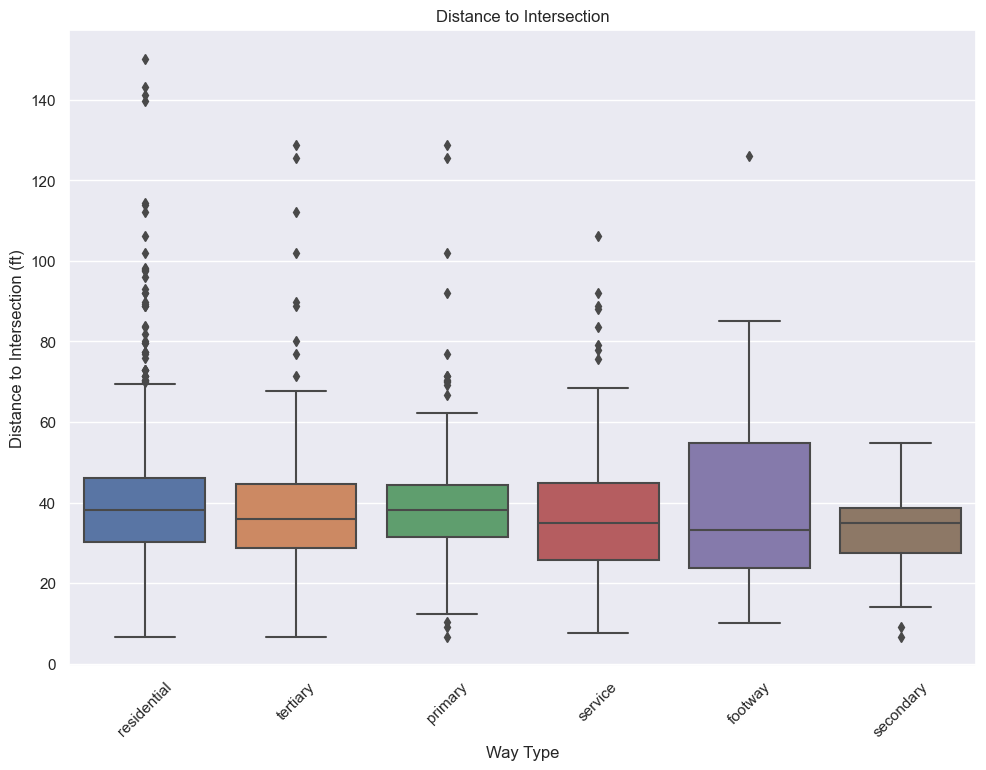

In [23]:
#select distance < 200 ft and do the same plot
distance_to_intersection = curb_to_intersection.loc[(curb_to_intersection['distance']<200)]
sns.set(rc={'figure.figsize':(11.7,8.27)})
ax = sns.boxplot(x="way_type", y="distance", data=distance_to_intersection)
ax.set_title('Distance to Intersection')
ax.set_xlabel('Way Type')
ax.set_ylabel('Distance to Intersection (ft)')
#rotate x-axis labels
plt.setp(ax.get_xticklabels(), rotation=45)
plt.show()

In [25]:
#select only label_id, way_type, distance
curb_to_intersection = curb_to_intersection[['label_id','way_type','distance']]

In [26]:
curb_to_intersection

,label_id,way_type,distance
0,9,residential,16.318492
2,11,residential,28.909092
5,14,residential,26.150583
6,15,residential,30.502388
6704,7151,residential,29.795785
...,...,...,...
12016,12842,service,23.455259
12103,13062,service,26.148425
12104,13063,service,34.668324
12107,13067,service,36.126124


In [27]:
#Spatial join project sidewalk labels to sidewalk geometry
no_curb_to_intersection = no_curb.sjoin_nearest(p_geo, distance_col='distance')
no_curb_to_intersection

,audit_task,label_id,gsv_panora,label_type,severity,correct,high_quali,gsv_pano_1,zoom,heading,pitch,photograph,photogra_1,user_id,lat,lng,geometry,index_right,coord,way_type,distance
10,7,19,Tu5MN4i-9qVTV2F-Hv7cMw,NoCurbRamp,3.0,1,1,Tu5MN4i-9qVTV2F-Hv7cMw,1,286.564728,-35.000000,198.437866,1.658447,503d2482-420f-454e-8118-aac2d22592aa,40.945396,-74.034119,POINT (13877641.238 1626357.335),863,"(-74.0340752, 40.9454833)",residential,34.105713
11,7,20,Tu5MN4i-9qVTV2F-Hv7cMw,NoCurbRamp,3.0,0,1,Tu5MN4i-9qVTV2F-Hv7cMw,1,73.564735,-23.000000,198.437866,1.658447,503d2482-420f-454e-8118-aac2d22592aa,40.945385,-74.034042,POINT (13877661.066 1626366.019),863,"(-74.0340752, 40.9454833)",residential,37.229758
12,7,21,8AsY4nlOJQAo8P5YYaEjzA,NoCurbRamp,3.0,1,1,8AsY4nlOJQAo8P5YYaEjzA,1,9.439733,-15.875000,108.536644,-0.496017,503d2482-420f-454e-8118-aac2d22592aa,40.945515,-74.033981,POINT (13877647.807 1626414.798),863,"(-74.0340752, 40.9454833)",residential,28.554251
13,7,22,Y5BVOQNX5JdRXdiQiKdHPA,NoCurbRamp,3.0,1,1,Y5BVOQNX5JdRXdiQiKdHPA,1,225.064728,-16.250000,199.918030,-0.549355,503d2482-420f-454e-8118-aac2d22592aa,40.945545,-74.034096,POINT (13877615.266 1626405.794),863,"(-74.0340752, 40.9454833)",residential,23.429943
45,8,56,7l-j4D7uhfKRQPpYXIU59w,NoCurbRamp,5.0,1,1,7l-j4D7uhfKRQPpYXIU59w,2,324.006683,-15.959822,20.765854,0.262733,503d2482-420f-454e-8118-aac2d22592aa,40.946316,-74.037010,POINT (13876787.936 1626174.517),1234,"(-74.0369754, 40.9462735)",primary,18.288256
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12099,2176,13043,o9ZptmEg7JNnJaPNdj6Djw,NoCurbRamp,1.0,None,1,o9ZptmEg7JNnJaPNdj6Djw,3,185.555801,-16.437500,289.178223,-0.541770,ce60454f-5d40-4649-a17a-562a46c57519,40.952457,-74.041946,POINT (13874372.532 1627240.026),1032,"(-74.041872, 40.9525346)",residential,35.088850
12100,2176,13044,IMvapJmUNJSNs64yB5Xefg,NoCurbRamp,4.0,0,1,IMvapJmUNJSNs64yB5Xefg,3,204.165176,-16.671875,289.768250,-0.903824,ce60454f-5d40-4649-a17a-562a46c57519,40.952419,-74.041824,POINT (13874408.414 1627247.939),1032,"(-74.041872, 40.9525346)",residential,44.358380
12129,2194,13096,28tGbhCsMyFUsKRs7-jp_A,NoCurbRamp,2.0,1,1,28tGbhCsMyFUsKRs7-jp_A,2,189.401779,-10.892858,287.290100,-2.176155,528eb1d6-e20e-4fb9-81c9-0c06b9e2852f,40.954376,-74.030624,POINT (13876556.096 1629618.128),327,"(-74.0305276, 40.9545273)",service,61.650246
12132,2202,13099,WkdNrR64GZUC1V_at1pxyA,NoCurbRamp,NaN,None,0,WkdNrR64GZUC1V_at1pxyA,1,178.687500,-8.625000,281.559601,-2.859410,0cfe6980-35ac-4cdd-a2df-cbee02531406,40.969189,-74.029976,POINT (13873597.650 1634183.325),1027,"(-74.02981, 40.9692902)",residential,59.315314


In [28]:
#select only label_id, way_type, distance
no_curb_to_intersection = no_curb_to_intersection[['label_id','way_type','distance']]

In [29]:
crosswalk_to_intersection = no_curb.sjoin_nearest(p_geo, distance_col='distance')
crosswalk_to_intersection

,audit_task,label_id,gsv_panora,label_type,severity,correct,high_quali,gsv_pano_1,zoom,heading,pitch,photograph,photogra_1,user_id,lat,lng,geometry,index_right,coord,way_type,distance
10,7,19,Tu5MN4i-9qVTV2F-Hv7cMw,NoCurbRamp,3.0,1,1,Tu5MN4i-9qVTV2F-Hv7cMw,1,286.564728,-35.000000,198.437866,1.658447,503d2482-420f-454e-8118-aac2d22592aa,40.945396,-74.034119,POINT (13877641.238 1626357.335),863,"(-74.0340752, 40.9454833)",residential,34.105713
11,7,20,Tu5MN4i-9qVTV2F-Hv7cMw,NoCurbRamp,3.0,0,1,Tu5MN4i-9qVTV2F-Hv7cMw,1,73.564735,-23.000000,198.437866,1.658447,503d2482-420f-454e-8118-aac2d22592aa,40.945385,-74.034042,POINT (13877661.066 1626366.019),863,"(-74.0340752, 40.9454833)",residential,37.229758
12,7,21,8AsY4nlOJQAo8P5YYaEjzA,NoCurbRamp,3.0,1,1,8AsY4nlOJQAo8P5YYaEjzA,1,9.439733,-15.875000,108.536644,-0.496017,503d2482-420f-454e-8118-aac2d22592aa,40.945515,-74.033981,POINT (13877647.807 1626414.798),863,"(-74.0340752, 40.9454833)",residential,28.554251
13,7,22,Y5BVOQNX5JdRXdiQiKdHPA,NoCurbRamp,3.0,1,1,Y5BVOQNX5JdRXdiQiKdHPA,1,225.064728,-16.250000,199.918030,-0.549355,503d2482-420f-454e-8118-aac2d22592aa,40.945545,-74.034096,POINT (13877615.266 1626405.794),863,"(-74.0340752, 40.9454833)",residential,23.429943
45,8,56,7l-j4D7uhfKRQPpYXIU59w,NoCurbRamp,5.0,1,1,7l-j4D7uhfKRQPpYXIU59w,2,324.006683,-15.959822,20.765854,0.262733,503d2482-420f-454e-8118-aac2d22592aa,40.946316,-74.037010,POINT (13876787.936 1626174.517),1234,"(-74.0369754, 40.9462735)",primary,18.288256
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12099,2176,13043,o9ZptmEg7JNnJaPNdj6Djw,NoCurbRamp,1.0,None,1,o9ZptmEg7JNnJaPNdj6Djw,3,185.555801,-16.437500,289.178223,-0.541770,ce60454f-5d40-4649-a17a-562a46c57519,40.952457,-74.041946,POINT (13874372.532 1627240.026),1032,"(-74.041872, 40.9525346)",residential,35.088850
12100,2176,13044,IMvapJmUNJSNs64yB5Xefg,NoCurbRamp,4.0,0,1,IMvapJmUNJSNs64yB5Xefg,3,204.165176,-16.671875,289.768250,-0.903824,ce60454f-5d40-4649-a17a-562a46c57519,40.952419,-74.041824,POINT (13874408.414 1627247.939),1032,"(-74.041872, 40.9525346)",residential,44.358380
12129,2194,13096,28tGbhCsMyFUsKRs7-jp_A,NoCurbRamp,2.0,1,1,28tGbhCsMyFUsKRs7-jp_A,2,189.401779,-10.892858,287.290100,-2.176155,528eb1d6-e20e-4fb9-81c9-0c06b9e2852f,40.954376,-74.030624,POINT (13876556.096 1629618.128),327,"(-74.0305276, 40.9545273)",service,61.650246
12132,2202,13099,WkdNrR64GZUC1V_at1pxyA,NoCurbRamp,NaN,None,0,WkdNrR64GZUC1V_at1pxyA,1,178.687500,-8.625000,281.559601,-2.859410,0cfe6980-35ac-4cdd-a2df-cbee02531406,40.969189,-74.029976,POINT (13873597.650 1634183.325),1027,"(-74.02981, 40.9692902)",residential,59.315314


In [30]:
#select only label_id, way_type, distance
crosswalk_to_intersection = crosswalk_to_intersection[['label_id','way_type','distance']]

In [34]:
#concatenate curb and no curb
intersection_d = pd.concat([curb_to_intersection, no_curb_to_intersection, crosswalk_to_intersection])

In [35]:
# rename distance to distance_to_intersection
intersection_d = intersection_d.rename(columns={'distance':'intersection_distance'})
intersection_d

,label_id,way_type,intersection_distance
0,9,residential,16.318492
2,11,residential,28.909092
5,14,residential,26.150583
6,15,residential,30.502388
6704,7151,residential,29.795785
...,...,...,...
12099,13043,residential,35.088850
12100,13044,residential,44.358380
12129,13096,service,61.650246
12132,13099,residential,59.315314


In [42]:
df = labels[['label_id']]

In [43]:
df

,label_id
0,9
1,10
2,11
3,12
4,13
...,...
12129,13096
12130,13097
12131,13098
12132,13099


In [44]:
#merge labels and intersection_d
df = df.merge(intersection_d, on='label_id', how='left')

In [45]:
#group by label_id choose first way_type and distance
df = df.groupby('label_id').first().reset_index()
df = df.fillna(-1)
df

,label_id,way_type,intersection_distance
0,9,residential,16.318492
1,10,-1,-1.000000
2,11,residential,28.909092
3,12,-1,-1.000000
4,13,-1,-1.000000
...,...,...,...
12129,13096,service,61.650246
12130,13097,-1,-1.000000
12131,13098,-1,-1.000000
12132,13099,residential,59.315314


In [46]:
df.to_csv('data/features/intersection_distance.csv', index=False)